# RateML

### Using RateML to generate a CUDA model file and Pyunicore to excute parameter sweeps on HPC cluster

In [ ]:
# !git clone https://github.com/DeLaVlag/tvb-root.git
from IPython.display import Markdown, display, Code

In [ ]:
import os
# install tvb-library
os.chdir("/mnt/user/drive/Shared with groups/RateML TVB/tvb-root/scientific_library/")
!python setup.py install
# os.chdir("/mnt/user/drive/Shared with groups/RateML TVB/tvb-root/tvb_bin/")
# install tvb-bin
# !python setup.py install
# install tvb-data
# ! pip install tvb-data
# os.chdir("/mnt/user/drive/Shared with groups/RateML TVB/")

## Building a model
Building rate based models in RateML, start by creating an XML model file. To understand which constructs can be used to build the model, one should take a closer look at the README file. The cell below will prints the latest README file from the repository. Every construct which can be used, is explained.

In [ ]:
mdfile = open("tvb-root/scientific_library/tvb/rateML/README.md","r")
model = mdfile.read()
display(Markdown(model))
mdfile.close()

## Generate a model
After reading the README, one should be able to build an XML model file. Lets use the relatively small Kuramoto model as an example. 
Your model should look like similar to the Kuramoto python file and define some constants, an exposure and dynamics behavior. The dynamics for the Kuramoto consist of a state variable, a derived variable and a time derivative. Except for the derived variable, there are the construct that a RateML XML model file should contain. The template: tvb-root/scientific_library/tvb/rateML/XMLmodels/model_template.xml is an empty template which can be used to create a model XML file.

In [ ]:
# Open the Kuramoto model
model_filename = "kuramoto"
model_location = "tvb-root/scientific_library/tvb/rateML/XMLmodels/"+model_filename+".xml"
!pwd
xmlfile = open(model_location,"r")
model = xmlfile.read()
display(Markdown(model))
xmlfile.close()

## Generating the model code

We will call the templating function in order to automatically generate the model code.
In XML2model.py the class 
```python
RateML('model_filename', language=('python' | 'cuda'), 'path/to/your/XMLmodels', 'path/to/your/generatedModels')
``` 
will start the code generation.

In [2]:
from tvb.rateML.XML2model import RateML

# some preexisting examples:
# model_filename = 'montbrio'
# model_filename = 'oscillator'
model_filename = 'kuramoto'
# model_filename = 'rwongwang'
# model_filename = 'epileptor'
language = "cuda"
XMLin = "tvb-root/scientific_library/tvb/rateML/XMLmodels/"
GenModOut = "tvb-root/scientific_library/tvb/rateML/generatedModels/"
RateML(model_filename, language, XMLin, GenModOut)

2020-12-02 12:07:37,556 - INFO - tvb.rateML.XML2model - True validation of tvb-root/scientific_library/tvb/rateML/XMLmodels/kuramoto.xml against https://raw.githubusercontent.com/DeLaVlag/tvb-root/xsdvalidation/scientific_library/tvb/rateML/rML_v0.xsd


In [ ]:
from IPython.display import Markdown, display, Code
# Open the generated model
model_location = "tvb-root/scientific_library/tvb/rateML/generatedModels/"+model_filename+".c"
genModFile = open(model_location,"r")
model = genModFile.read()
display(Code(model, language='c'))
# display(Markdown(model))
genModFile.close()

## Simulating the result
If the model displays all its features to your whishes, it is time to take her for a spin on a GPU. The sites that are able to run the models are the JUSUF and JUWELS clusters from Forschungszentrum Juelich. This will only work if you have an LDAP account for these clusters and you are registered in the PyUnicore database. If you dont have access any other CUDA enabled GPU will run your generated model, using \_\_main\_\_.py in rateML/run/ folder .

### Setup PyUnicore

In [3]:
# !pip install pyunicore --upgrade
import pyunicore.client as unicore_client
import json
import os

In [4]:
token = clb_oauth.get_token()
tr = unicore_client.Transport(token)
r = unicore_client.Registry(tr, unicore_client._HBP_REGISTRY_URL)
# r.site_urls
# HPC_LOC = "https://zam2125.zam.kfa-juelich.de:9112/JUSUF/rest/core"
HPC_LOC = 'https://zam2125.zam.kfa-juelich.de:9112/JUWELS/rest/core'
site = unicore_client.Client(transport=tr,site_url=HPC_LOC)

2020-12-02 12:07:48,180 - DEBUG - urllib3.connectionpool - Starting new HTTP connection (1): jupyterhub:8080
2020-12-02 12:07:48,251 - DEBUG - urllib3.connectionpool - http://jupyterhub:8080 "GET /services/access-token-service/access-token HTTP/1.1" 200 1475
2020-12-02 12:07:48,256 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): hbp-unic.fz-juelich.de:7112
2020-12-02 12:07:48,431 - DEBUG - urllib3.connectionpool - https://hbp-unic.fz-juelich.de:7112 "GET /HBP/rest/registries/default_registry HTTP/1.1" 200 None
2020-12-02 12:07:48,451 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): zam2125.zam.kfa-juelich.de:9112
2020-12-02 12:07:50,000 - DEBUG - urllib3.connectionpool - https://zam2125.zam.kfa-juelich.de:9112 "GET /JUWELS/rest/core HTTP/1.1" 200 6972


### Transfer model
Transfer the generated model file to JUSUF.

In [5]:
base_url = HPC_LOC + "/storages/PROJECT/"
# base_url = "https://zam2125.zam.kfa-juelich.de:9112/JUSUF/rest/core/storages/PROJECT/"
source_location = "drive/Shared with groups/RateML TVB/tvb-root/scientific_library/tvb/rateML/generatedModels/" + model_filename + ".c"
source_path = os.path.join(os.environ['HOME'], source_location)

storage = unicore_client.Storage(tr, base_url)
storage_location = "wikicollab/RateML/" + model_filename + ".c"
storage.upload(source_path, destination = storage_location)

2020-12-02 12:07:58,590 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): zam2125.zam.kfa-juelich.de:9112
2020-12-02 12:08:00,108 - DEBUG - urllib3.connectionpool - https://zam2125.zam.kfa-juelich.de:9112 "PUT /JUWELS/rest/core/storages/PROJECT/files/wikicollab/RateML/kuramoto.c HTTP/1.1" 204 0


### Job setup

Before the can be executed on HPC some other parameters need to be setup as well

We specify a grid of parameter values to sweep, which will be setup the HPC according to:
```python
couplings = np.logspace(1.6, 3.0, coupling)
speeds = np.logspace(0.0, 2.0, speed)
params_iter = itertools.product(speeds, couplings)
params = np.array([vals for vals in params_iter], np.float32)
```
by setting the coupling and speed sizes:

In [6]:
coupling = "32"
speed = "32"

The simulation time

In [118]:
simtime = "400"

The default values of 66, 68, 76, 80, 96, 192 or 998 can be selected and is processed accordingly:
```python
connectivity = Connectivity.from_file(source_file="connectivity_"+n_nodes+".zip")
```

In [8]:
n_nodes = "68"

Set the number of states of your model. The Kuramoto has 1, ReducedWongWang, Generic2DOscillator and Montbrio have 2 and Epileptor has 6 states. 

In [9]:
states = "1"

In [147]:
model_filename = "Kuramotoref"

#### Create the unicore job:

In [148]:
my_job = {}

# executable / application
# arguments for runthingsJusuf are: backend modelname couplings speeds
my_job['Executable'] = "source /p/project/cslns/wikicollab/RateML/activate; \
cd /p/project/cslns/wikicollab/RateML/; \
./runthingsJuwels "+model_filename+" "+coupling+" "+speed+" "+simtime+" "+n_nodes+" "+states
# ./runthingsJuwels "+model_filename+" 32 32"
# ./runthingsJusuf "+model_filename+ " 32 32;"

# environment vars
# run this on login node, not in batch system
my_job['RunOnLoginNode'] = "true"

my_job['Job type'] = "interactive"

# data stage in - TBD
my_job['Imports'] = []

# data stage out - TBD
my_job['Exports'] = []

# Resources - TBD
my_job['Resources'] = {}
my_job

{'Executable': 'source /p/project/cslns/wikicollab/RateML/activate; cd /p/project/cslns/wikicollab/RateML/; ./runthingsJuwels Kuramotoref 32 32 400 68 1',
 'RunOnLoginNode': 'true',
 'Job type': 'interactive',
 'Imports': [],
 'Exports': [],
 'Resources': {}}

#### Submit Job to selected HPC cluster 

In [149]:
job = site.new_job(job_description=my_job)

2020-12-02 17:10:48,932 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): zam2125.zam.kfa-juelich.de:9112
2020-12-02 17:10:51,595 - DEBUG - urllib3.connectionpool - https://zam2125.zam.kfa-juelich.de:9112 "POST /JUWELS/rest/core/jobs HTTP/1.1" 201 None


### Info about JOB

In [150]:
if(job.is_running()):
    print('Job is running')

job.poll()
print('Job is finished')

2020-12-02 17:10:55,678 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): zam2125.zam.kfa-juelich.de:9112
2020-12-02 17:10:55,916 - DEBUG - urllib3.connectionpool - https://zam2125.zam.kfa-juelich.de:9112 "GET /JUWELS/rest/core/jobs/ef2cb341-06a8-4880-8991-b61439208ff0 HTTP/1.1" 200 4898
Job is running
2020-12-02 17:10:55,918 - DEBUG - pyunicore.client - Sleeping 5.1
2020-12-02 17:11:01,026 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): zam2125.zam.kfa-juelich.de:9112
2020-12-02 17:11:01,332 - DEBUG - urllib3.connectionpool - https://zam2125.zam.kfa-juelich.de:9112 "GET /JUWELS/rest/core/jobs/ef2cb341-06a8-4880-8991-b61439208ff0 HTTP/1.1" 200 4898
2020-12-02 17:11:01,334 - DEBUG - pyunicore.client - Sleeping 5.1
2020-12-02 17:11:06,441 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): zam2125.zam.kfa-juelich.de:9112
2020-12-02 17:11:06,723 - DEBUG - urllib3.connectionpool - https://zam2125.zam.kfa-juelich.de:9112 "GET /JUWE

### Fetch results
Copy the output log from cluster to Collab

In [101]:
remote = storage.stat("wikicollab/RateML/output.out")
remote.download("output.out")

with open("output.out", "r") as f:
    for line in f:
        print (line.rstrip())

2020-12-02 14:56:06,590 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): zam2125.zam.kfa-juelich.de:9112
2020-12-02 14:56:07,476 - DEBUG - urllib3.connectionpool - https://zam2125.zam.kfa-juelich.de:9112 "GET /JUWELS/rest/core/storages/PROJECT/ HTTP/1.1" 200 1240
2020-12-02 14:56:07,481 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): zam2125.zam.kfa-juelich.de:9112
2020-12-02 14:56:09,588 - DEBUG - urllib3.connectionpool - https://zam2125.zam.kfa-juelich.de:9112 "GET /JUWELS/rest/core/storages/PROJECT/files/wikicollab/RateML/output.out HTTP/1.1" 200 281
2020-12-02 14:56:09,592 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): zam2125.zam.kfa-juelich.de:9112
2020-12-02 14:56:10,556 - DEBUG - urllib3.connectionpool - https://zam2125.zam.kfa-juelich.de:9112 "GET /JUWELS/rest/core/storages/PROJECT/files/wikicollab/RateML/output.out HTTP/1.1" 200 195
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not foun

Copy the error log from JUSUF to Collab

In [151]:
remote = storage.stat("wikicollab/RateML/error.er")
remote.download("error.er")

with open("error.er", "r") as f:
    for line in f:
        print (line.rstrip())

2020-12-02 17:11:44,350 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): zam2125.zam.kfa-juelich.de:9112
2020-12-02 17:11:45,056 - DEBUG - urllib3.connectionpool - https://zam2125.zam.kfa-juelich.de:9112 "GET /JUWELS/rest/core/storages/PROJECT/ HTTP/1.1" 200 1240
2020-12-02 17:11:45,061 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): zam2125.zam.kfa-juelich.de:9112
2020-12-02 17:11:45,967 - DEBUG - urllib3.connectionpool - https://zam2125.zam.kfa-juelich.de:9112 "GET /JUWELS/rest/core/storages/PROJECT/files/wikicollab/RateML/error.er HTTP/1.1" 200 282
2020-12-02 17:11:45,971 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): zam2125.zam.kfa-juelich.de:9112
2020-12-02 17:11:46,840 - DEBUG - urllib3.connectionpool - https://zam2125.zam.kfa-juelich.de:9112 "GET /JUWELS/rest/core/storages/PROJECT/files/wikicollab/RateML/error.er HTTP/1.1" 200 1700
/p/project/cslns/vandervlag1/cuda_only/tvb-hpc/tvb-root/scientific_library/tvb/dat

#### Transfer the produced data from HPC

In [152]:
remote = storage.stat("wikicollab/RateML/tavg_data")
remote.download("tavg_data")

2020-12-02 17:12:12,333 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): zam2125.zam.kfa-juelich.de:9112
2020-12-02 17:12:13,355 - DEBUG - urllib3.connectionpool - https://zam2125.zam.kfa-juelich.de:9112 "GET /JUWELS/rest/core/storages/PROJECT/ HTTP/1.1" 200 1240
2020-12-02 17:12:13,359 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): zam2125.zam.kfa-juelich.de:9112
2020-12-02 17:12:14,068 - DEBUG - urllib3.connectionpool - https://zam2125.zam.kfa-juelich.de:9112 "GET /JUWELS/rest/core/storages/PROJECT/files/wikicollab/RateML/tavg_data HTTP/1.1" 200 287
2020-12-02 17:12:14,072 - DEBUG - urllib3.connectionpool - Starting new HTTPS connection (1): zam2125.zam.kfa-juelich.de:9112
2020-12-02 17:12:14,858 - DEBUG - urllib3.connectionpool - https://zam2125.zam.kfa-juelich.de:9112 "GET /JUWELS/rest/core/storages/PROJECT/files/wikicollab/RateML/tavg_data HTTP/1.1" 200 None


#### Unpickle it

In [153]:
import pickle
tavg_file = open('tavg_data', 'rb')
tavg_data = pickle.load(tavg_file)
tavg_file.close()
tavg_data.shape
tavg_data[...,0].shape

(400, 68)

#### Plot the data

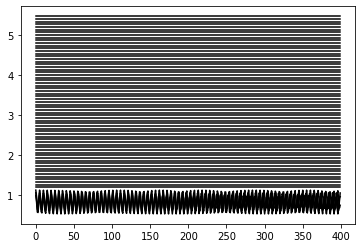

In [156]:
from pylab import *
import numpy as np
plot(np.cos(tavg_data[..., 0]) + np.r_[:68]/15.0, 'k')
show()

In [158]:
import tqdm
cc = np.zeros((1024, 68, 68), 'f')
for i in tqdm.trange(1024):
    cc[i] = np.corrcoef(tavg_data[..., 0].T)

  0%|          | 0/1024 [00:00<?, ?it/s]/opt/app-root/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/app-root/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 1024/1024 [00:01<00:00, 952.22it/s]


In [159]:
l2 = np.sqrt(np.sum(np.sum((cc - weights)**2, axis=-1), axis=-1)).reshape((32, 32))

NameError: name 'weights' is not defined

In [ ]:
%pylab inline
imshow(l2)